### Алгоритм Нелдера-Мида

In [21]:
import numpy as np

def quadratic_function(x):
    """
    Quadratic objective function.
    """
    return np.sum((x - 2)**2)

def nelder_mead_step(func, simplex, alpha, beta, gamma, delta):
    """
    Perform one iteration of the Nelder-Mead algorithm.
    
    Parameters:
    - func: Objective function to minimize.
    - simplex: Current simplex, a list of points in N-dimensional space.
    - alpha, beta, gamma, delta: Parameters for reflection, expansion, contraction, and shrink.
    
    Returns:
    - simplex: Updated simplex after one iteration.
    """
    
    simplex = simplex[np.argsort([func(x) for x in simplex])]

    centroid = simplex[:-1].mean(axis=0)

    # Reflection
    xr = centroid + alpha * (centroid - simplex[-1])
    if func(simplex[0]) <= func(xr) < func(simplex[-2]):
        simplex[-1] = xr
        return simplex

    # Expansion
    if func(xr) < func(simplex[0]):
        xe = centroid + beta * (xr - centroid)
        simplex[-1] = xe if func(xe) < func(xr) else xr
        return simplex

    # Contraction
    xc = (centroid + gamma * (simplex[-1] - centroid) 
          if func(xr) >= func(simplex[-2]) 
          else centroid + gamma * (xr - centroid))
    if func(xc) < func(simplex[-1]):
        simplex[-1] = xc
        return simplex

    simplex[1:] = simplex[0] + delta * (simplex[1:] - simplex[0])
    return simplex

def nelder_mead(func, initial_simplex, max_iter=100, tol=1e-6, adaptive=False):
    """
    Nelder-Mead algorithm for optimization.
    
    Parameters:
    - func: Objective function to minimize.
    - initial_simplex: Initial simplex, a list of points in N-dimensional space.
    - max_iter: Maximum number of iterations.
    - tol: Convergence tolerance.
    - adaptive: Whether to use adaptive parameters.
    
    Returns:
    - best_point: Estimated minimum point.
    """
    n = len(initial_simplex) 
    if adaptive:
        alpha, beta, gamma, delta = 1, 1 + 2/n, 0.75 - 1/(2*n), 1 - 1/n
    else:
        alpha, beta, gamma, delta = 1, 2, 0.5, 0.5

    simplex = np.array(initial_simplex)

    for _ in range(max_iter):
        simplex = nelder_mead_step(func, simplex, alpha, beta, gamma, delta)

        if np.max(np.abs(simplex[0] - simplex[-1])) < tol:
            break

    return simplex[0]

In [22]:
initial_simplex = [np.array([-5.0, -4.0]), np.array([-4, -3]), np.array([-2, -1.5])]
n = len(initial_simplex)  # Dimension of the problem

alpha, beta, gamma, delta = 1, 1 + 2/n, 0.75 - 1/(2*n), 1 - 1/n

simplex = np.array(initial_simplex)

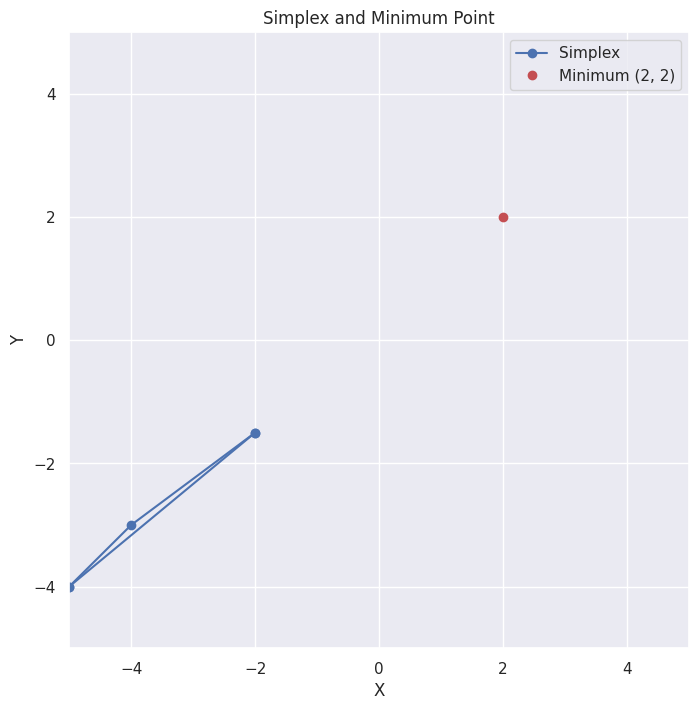

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set()

plt.figure(figsize=(8, 8))
plt.plot(*zip(*simplex), 'bo-', label='Simplex')
plt.plot([simplex[-1][0], simplex[0][0]], [simplex[-1][1], simplex[0][1]], 'bo-')

plt.plot(2, 2, 'ro', label='Minimum (2, 2)')

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Simplex and Minimum Point')

plt.grid(True)
plt.show()

simplex = nelder_mead_step(quadratic_function, simplex, alpha, beta, gamma, delta)

### Сравнения

In [24]:
import numpy as np
from scipy.optimize import minimize
import time
import pandas as pd

def rosenbrock(x):
    return sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

results = []

for method in methods:
    mean_el_time = 0
    for i in range(1000):
        start_time = time.time()
        res = minimize(rosenbrock, x0, method=method)
        elapsed_time = time.time() - start_time
        mean_el_time += elapsed_time
    results.append({'Method': method, 'Time (s)': elapsed_time / 100, 'Iterations': res.nit if 'nit' in res else 'N/A', 'Success': res.success})

df = pd.DataFrame(results).sort_values('Time (s)')
df

,Method,Time (s),Iterations,Success
0,Nelder-Mead,0.000056,141,True
4,L-BFGS-B,0.000061,24,True
7,SLSQP,0.000078,27,True
3,BFGS,0.000080,25,True
1,Powell,0.000175,18,True
5,TNC,0.000177,20,True
6,COBYLA,0.000188,N/A,False
2,CG,0.000378,65,True


In [31]:
def rosen_der (x):
    xm = x [1: -1]
    xm_m1 = x [: - 2]
    xm_p1 = x [2:]
    der = np.zeros_like (x)
    der [1: -1] = 200 * (xm-xm_m1 ** 2) - 400 * (xm_p1 - xm ** 2) * xm - 2 * (1-xm)
    der [0] = -400 * x [0] * (x [1] -x [0] ** 2) - 2 * (1-x [0])
    der [-1] = 200 * (x [-1] -x [-2] ** 2)
    return der

results = []

mean_el_time = 0
for i in range(100):
    start_time = time.time()
    res = minimize(rosenbrock, x0, method='BFGS', jac=rosen_der)
    elapsed_time = time.time() - start_time
    mean_el_time += elapsed_time
results.append({'Method': 'BFGS', 'Time (s)': elapsed_time / 100, 'Iterations': res.nit if 'nit' in res else 'N/A', 'Success': res.success})


df = pd.DataFrame(results).sort_values('Time (s)')
df

,Method,Time (s),Iterations,Success
0,BFGS,0.000029,22,True


In [35]:
def rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

results = []

mean_el_time = 0
for i in range(100):
    start_time = time.time()
    res = minimize(rosenbrock, x0, method='Newton-CG', jac=rosen_der, hess=rosen_hess)
    elapsed_time = time.time() - start_time
    mean_el_time += elapsed_time
results.append({'Method': 'Newton-CG', 'Time (s)': elapsed_time / 100, 'Iterations': res.nit if 'nit' in res else 'N/A', 'Success': res.success})

df = pd.DataFrame(results).sort_values('Time (s)')
df

,Method,Time (s),Iterations,Success
0,Newton-CG,0.000043,24,True


In [39]:
import numpy as np
from scipy.optimize import minimize
import time
import pandas as pd

def kornev_trol(x):
    return np.sum(np.array([np.arctan(x[0] - 3.62) + np.power(x[1] - 4.12, 5.0), 
                           -np.power(x[0] - 3.62, 3.0) + (np.power(np.abs(x[1] - 4.12), 1/3.0) * (-1 if x[0] - 4.12 < 0 else 1))])**2)


x0 = np.array([1., 2.])

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

results = []

for method in methods:
    mean_el_time = 0
    for i in range(100):
        start_time = time.time()
        res = minimize(rosenbrock, x0, method=method)
        elapsed_time = time.time() - start_time
        mean_el_time += elapsed_time
    results.append({'Method': method, 'Time (s)': elapsed_time / 100, 'Iterations': res.nit if 'nit' in res else 'N/A', 'Success': res.success})

df = pd.DataFrame(results).sort_values('Time (s)')
df

,Method,Time (s),Iterations,Success
0,Nelder-Mead,0.000020,47,True
7,SLSQP,0.000022,11,True
4,L-BFGS-B,0.000039,22,True
1,Powell,0.000054,12,True
5,TNC,0.000058,12,True
2,CG,0.000122,22,True
3,BFGS,0.000143,21,False
6,COBYLA,0.000182,N/A,False
